## OCR 기술의 개요

OCR(Optical Character Recognition) = Text detection + Text recognition

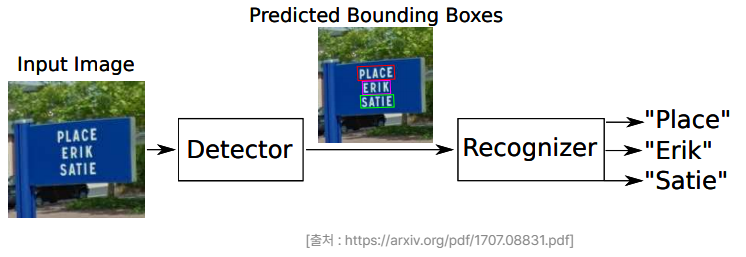

In [1]:
from IPython.display import Image
Image(filename='capture/ocr.png') 

### Before Deep Learning

주로 Tesseract OCR 을 사용함
- 1985년 휴렛 패커드사에서 개발 -> 2005년에 오픈소스로 출시
- 2006년부터 구글의 후원을 받는 오픈소스 OCR 엔진임

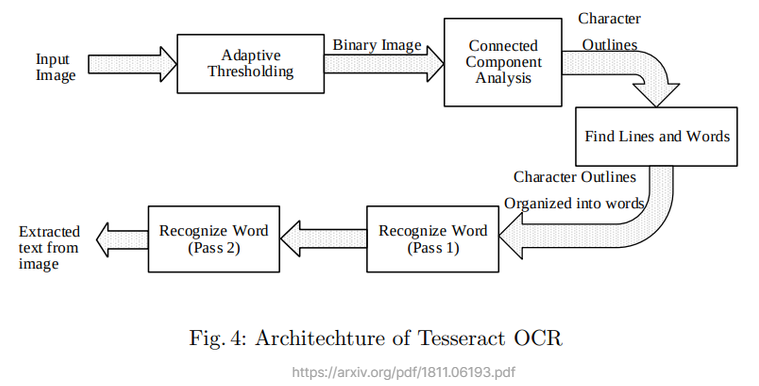

In [2]:
from IPython.display import Image
Image(filename='capture/tesseract_ocr.png') 

### Text detection

대표적인 것들

#### 1) Regression

- 딥러닝 기반의 Detection을 이용하여 단어 단위로 인식
- 일반적으로 단어들은 가로로 길기 때문에 Aspect ratio(종횡비)가 큼
  - 이에 따라 몇 가지 변형을 주게 된다.
  - 기존의 SSD에서는 Regression을 위한 Convolution layer에서 3x3 크기의 kernel을 갖는다.
  - 여기서는 1x5 크기의 convolution filter 를 사용한다.
- TextBoxes

#### 2) Segmentation

- PixelLink

#### 3) 최근 방법

3.1 CRAFT
- 문자(Character) 단위로 문자의 위치를 찾아낸 뒤, 이를 연결하는 방식을 Segmentation 기반으로 구현한 방법
- 문자의 영역을 boundary로 명확히 구분하지 않고, 가우시안 분포를 따르는 원형의 score map을 만들어서 배치시키는 방법으로 문자의 영역을 학습
- https://arxiv.org/abs/1904.01941 참고

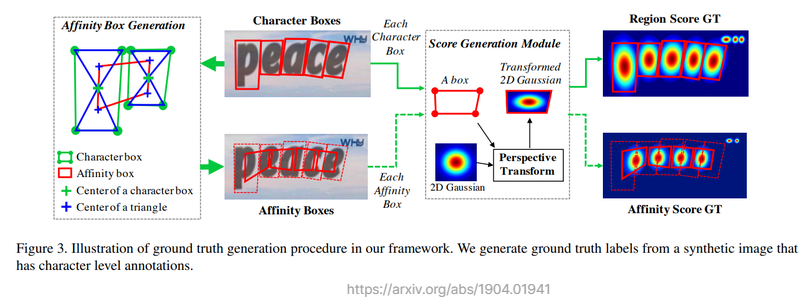

In [4]:
from IPython.display import Image
Image(filename='capture/craft.png') 

3.2 Pyramid Mask Text Detector
- https://arxiv.org/pdf/1903.11800.pdf 참고

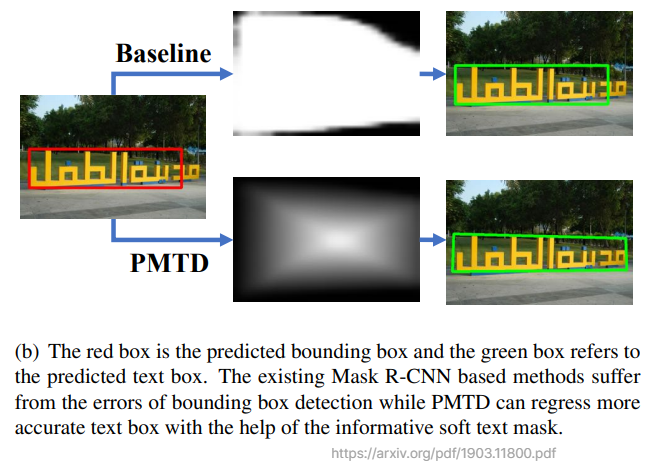

In [5]:
from IPython.display import Image
Image(filename='capture/pmtd.png') 

### Text recognition

#### CNN 과 RNN 의 만남 CRNN

- https://arxiv.org/pdf/1507.05717.pdf 참고
- 문자 이미지에서 정보 추출을 위해서는 Feature Extractor 가 필요함 -> 이 때 CNN 사용 (VGG 또는 ResNet 과 같은)
- 이렇게 추출된 Feature 를 Map-To-Sequence 를 토해 Sequence 형태의 feature 로 변환
- 변환된 feature 를 다양한 길이의 input 을 처리할 수 있는 RNN 으로 입력

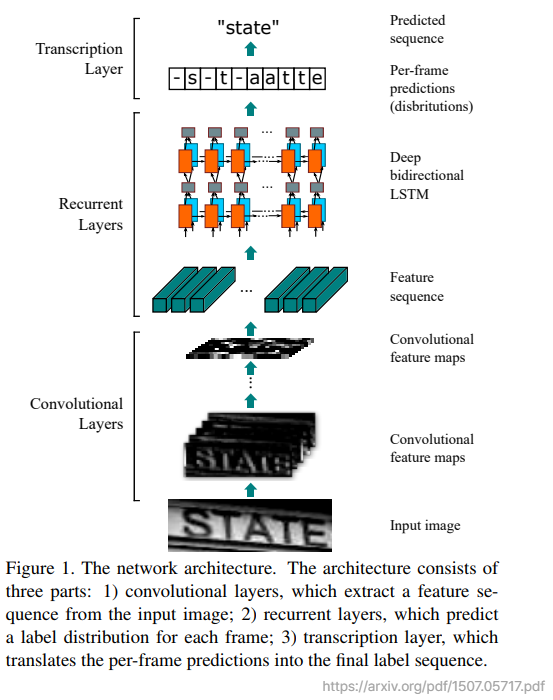

In [6]:
from IPython.display import Image
Image(filename='capture/rcnn.png') 

#### CTC

앞서 설명한 CRNN 에서는 Step 마다 Fully Connected Layer 의 logit 을 Softmax 함수에 넣어줌으로써 어떤 문자일 확률이 높은지 알 수 있는데

이 결과 그대로를 문자로 변환하면 기대한 것과 다른 결과가 나온다.

왜냐하면,
- output 은 24개의 글자로 이뤄진 sequence 지만, 실제 결과는 이와 다르기 때문이다.
- 예를 들어 "HELLO" 라는 이미지에 대해서는 output 은 "HHEEELLLOOOOO..."와 같이 24자의 sequence 이기 때문이다.

그렇다면 이 24자의 sequqnce 를 실제 인식 결과로 바꾸기 위해서 어떤 방법을 써야 할까?

CRNN에서는 CTC(Connectionist Temporal Classification)를 활용
- http://www.cs.toronto.edu/~graves/icml_2006.pdf 참고

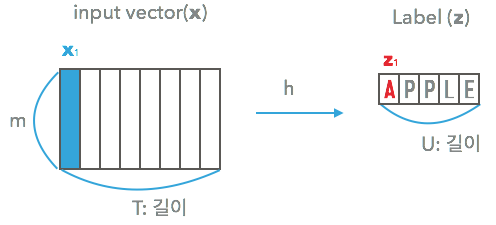

In [7]:
from IPython.display import Image
Image(filename='capture/ctc.png') 

위에서 본 "HHHEEELLLOOOOO..."를 "HELLO"로 만들기 위해서는 
- 중복되는 단어인 "HHHH..."나 "EEE...", "LLL..."들을 "H", "E", "L" 등으로 바꿔볼 수 있다.
- 그러면 "HELO"가 될 것이다. 

그렇다면 "L"이 두 번 중복되는 경우에는 어떻게 구분?

- 앞서 봤던 Label Encode에서 이렇게 같은 문자를 구분하기 위한 Blank를 중복된 라벨 사이를 구분하기 위해 넣어준다.
- 아래 그림은 Blank token을 '-'로 대신하여 Output을 만드는 Decoder를 의미한다. 
- Decode 후에 중복을 제거하고, 인식할 문자가 아닌 값을 지워주면 "HELLO"라는 결과를 얻을 수 있다.

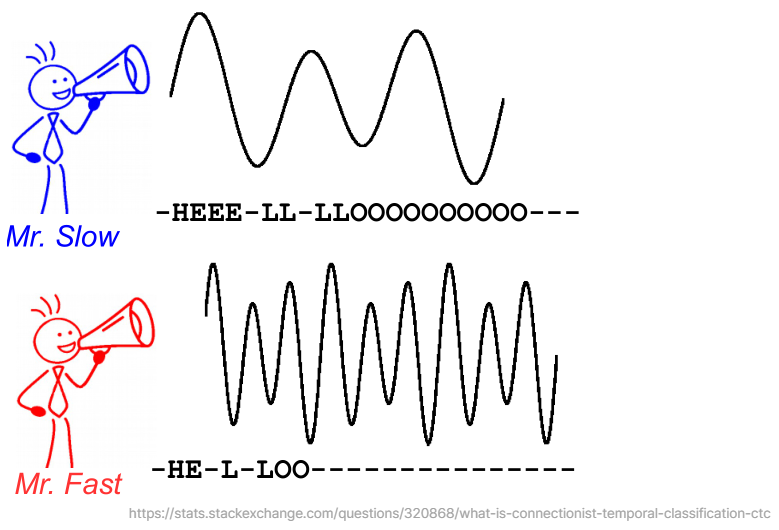

In [8]:
from IPython.display import Image
Image(filename='capture/ctc_explain.png') 

#### TPS

책이 아닌 거리의 글자를 읽을 때, OCR이 어려워지는 이유는 불규칙한 방향이나 휘어진 진행 방향 때문이다.

- https://arxiv.org/pdf/1603.03915.pdf 참고
- Thin Plate Spline (TPS) Transformation을 적용하여 입력 이미지를 단어 영역에 맞게 변형 시켜 인식이 잘되도록 해준다.
  - Thin plate spline은 control point를 정의하고 해당 point들이 특정 위치로 옮겨졌을 때, 축 방향의 변화를 interpolation하여 모든 위치의 변화를 추정해낸다.
  - 이를 통해서 전체 이미지 pixel의 변화를 control point로 만들어낼 수 있다.

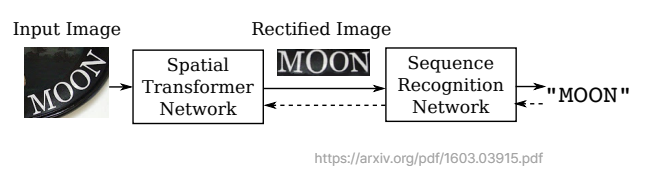

In [9]:
from IPython.display import Image
Image(filename='capture/tps.png')

### Text recognition + Attention

Attention과 Transformer가 딥러닝 분야에 큰 변화를 가져왔고, OCR 분야도 예외는 아니다.

1. Attention sequence prediction
- Attention기반의 sequence prediction은 문장의 길이를 고정하고, 입력되는 Feature에 대한 Attention을 기반으로 해당 글자의 Label을 prediction 한다.
- 필요에 따라서 예외처리나 공백을 위한 token 을 만들어서 사용하기도 한다.
- https://arxiv.org/pdf/1603.03915.pdf 참고
- https://arxiv.org/pdf/1709.02054.pdf 참고

2. Transformer와 함께!
- Transformer도 Recognition 모델에 활용되기 시작한다.
- "A Simple and Robust Convolutional-Attention Network for Irregular Text Recognition"가 대표적인 논문
  - https://arxiv.org/pdf/1904.01375v1.pdf 참고
- https://hulk89.github.io/machine%20learning/2019/05/15/A-Simple-and-Robust-Convolutional-Attention-Network-For-Irregular-Text-Recognition/ 리뷰 참고
- Irregular text를 잘 인식하기 위해서 2d space에 대한 attention을 활용하여 문자를 인식하기 위해 Transformer를 활용

Transformer는 Query, Key, Value라는 개념을 통해서 Self-Attention을 입력으로부터 만들어낸다.  
이를 통해서 입력에서 중요한 Feature에 대해 Weight를 주게 된다.

Attention의 핵심은 Decoder의 현재 포지션에서 중요한 Encoder의 State에 가중치가 높게 매겨진다는 점이다.

아래는 Attention이 시각화된 이미지를 눈으로 볼 수 있는데요, Decoder의 각 Step에 따라 입력에 대한 Visual Attention이 시각화된 모습이다.

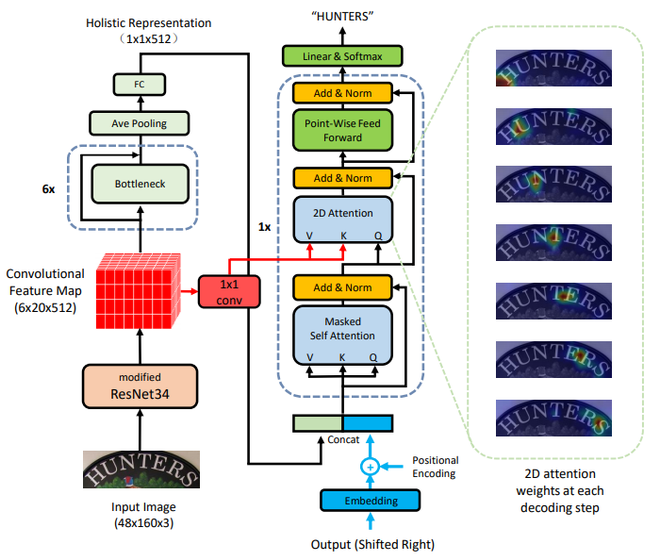

In [10]:
from IPython.display import Image
Image(filename='capture/text_recognition_with_transformer.png')